In [1]:
%pwd

'/home/acr/Documents/Projeto Sistemas Mecatrónicos/Demand Response'

In [2]:
import gym
import Antonio_FlexEnv as flex

import Antonio_auxfunctions as fun

import stable_baselines3

from stable_baselines3 import DQN, A2C
from stable_baselines3.a2c.policies import MlpPolicy

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env

from stable_baselines3 import SAC
from stable_baselines3 import DDPG

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

from stable_baselines3.ddpg.policies import MlpPolicy


import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy.random as rnd
import time
import random as rnd

from time import perf_counter


# Data and Environment preparation

In [3]:
#Data
cwd=os.getcwd()
datafolder=cwd + '/Data'

#impor the data csv
env_data=pd.read_csv(datafolder + '/env_data.csv', header = None)

#make and check the environment
# Select the number of timesteps to consider
# timesteps=141
timesteps=47

#Create environment. Based on the aux functions code.
env=fun.make_env(env_data, load_num=4, timestep=timesteps, soc_max=2, eta=0.95, charge_lim=3, min_charge_step=0.2)

In [4]:
env.observation_space

Box([   0.    0.    0.    0.    0.    0. -100.    0. -100.], [ 47.  10.  10.   2.   2.   1. 100.   1. 100.], (9,), float32)

In [5]:
env.observation_space.high[3]

2.0

In [6]:
env.action_space

Discrete(15)

In [1]:
# help(env.action_space)

In [8]:
# charge_steps

In [9]:
data=env_data
load_num=4
timestep=timesteps

env_data
env_data1=data.to_numpy()
load=env_data1[0:timestep,load_num]
gen=abs(env_data1[0:timestep,1])
data1=np.vstack((0.5*gen,6*load)).T

In [10]:
env_data

,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-01-01 00:00:00,0.0,0.023,0.489,0.033,0.039,0.082,0.326,0.786,0.016,0.238,0.084
1,2017-01-01 00:30:00,-0.0,0.046,0.490,0.075,0.040,0.099,0.224,0.759,0.013,0.442,0.082
2,2017-01-01 01:00:00,-0.0,0.020,0.493,0.031,0.086,0.088,0.132,0.771,0.008,0.395,0.125
3,2017-01-01 01:30:00,-0.0,0.042,0.494,0.084,0.133,0.104,0.203,0.727,0.016,0.283,0.118
4,2017-01-01 02:00:00,-0.0,0.032,0.503,0.095,0.064,0.077,0.063,0.711,0.033,0.450,0.159
...,...,...,...,...,...,...,...,...,...,...,...,...
8683,2017-06-30 21:30:00,-0.0,0.085,0.123,0.092,0.131,0.072,0.227,0.344,0.007,0.190,0.171
8684,2017-06-30 22:00:00,-0.0,0.025,0.116,0.129,0.133,0.030,0.199,0.332,0.041,0.144,0.174
8685,2017-06-30 22:30:00,-0.0,0.059,0.111,0.089,0.096,0.059,0.192,0.276,0.035,0.407,0.211
8686,2017-06-30 23:00:00,-0.0,0.024,0.094,0.093,0.067,0.083,0.193,0.283,0.090,0.169,0.178


In [11]:
env_data[4]

0       0.033
1       0.075
2       0.031
3       0.084
4       0.095
        ...  
8683    0.092
8684    0.129
8685    0.089
8686    0.093
8687    0.078
Name: 4, Length: 8688, dtype: float64

In [12]:
env_data1.shape # 1a coluna é a data, 2a é a geração, 3a a 12a são colunas de gastos energéticos

(8688, 12)

In [13]:
env_data1

array([['2017-01-01 00:00:00', 0.0, 0.023, ..., 0.016, 0.238, 0.084],
       ['2017-01-01 00:30:00', -0.0, 0.046, ..., 0.013, 0.442, 0.082],
       ['2017-01-01 01:00:00', -0.0, 0.02, ..., 0.008, 0.395, 0.125],
       ...,
       ['2017-06-30 22:30:00', -0.0, 0.059, ..., 0.035, 0.407, 0.211],
       ['2017-06-30 23:00:00', -0.0, 0.024, ..., 0.09, 0.169, 0.178],
       ['2017-06-30 23:30:00', -0.0, 0.056, ..., 0.099, 0.18, 0.257]],
      dtype=object)

In [14]:
load.shape

(47,)

In [15]:
env_data1[0:timestep,4] # É só um dia de dados 

array([0.033, 0.075, 0.031, 0.084, 0.095, 0.106, 0.099, 0.042, 0.071,
       0.028, 0.076, 0.037, 0.064, 0.054, 0.097, 0.12, 0.074, 0.079,
       0.034, 0.068, 0.05, 0.053, 0.062, 0.037, 0.121, 0.073, 0.12, 0.048,
       0.057, 0.06, 0.042, 0.075, 0.025, 0.077, 0.088, 0.111, 0.098,
       0.053, 0.065, 0.036, 0.075, 0.026, 0.073, 0.042, 0.098, 0.107,
       0.09], dtype=object)

In [16]:
data1 # # Duas colunas, a primeira retrata a geração, a segunda representa os gastos energéticos da casa 

array([[0.0, 0.198],
       [0.0, 0.44999999999999996],
       [0.0, 0.186],
       [0.0, 0.504],
       [0.0, 0.5700000000000001],
       [0.0, 0.636],
       [0.0, 0.5940000000000001],
       [0.0, 0.252],
       [0.0, 0.42599999999999993],
       [0.0, 0.168],
       [0.0, 0.45599999999999996],
       [0.0, 0.22199999999999998],
       [0.0, 0.384],
       [0.0, 0.324],
       [0.0, 0.5820000000000001],
       [0.0, 0.72],
       [0.012, 0.44399999999999995],
       [0.05, 0.474],
       [0.115, 0.20400000000000001],
       [0.1975, 0.40800000000000003],
       [0.298, 0.30000000000000004],
       [0.3535, 0.318],
       [0.379, 0.372],
       [0.419, 0.22199999999999998],
       [0.551, 0.726],
       [0.4715, 0.43799999999999994],
       [0.3345, 0.72],
       [0.4165, 0.28800000000000003],
       [0.3045, 0.342],
       [0.1135, 0.36],
       [0.141, 0.252],
       [0.1525, 0.44999999999999996],
       [0.076, 0.15000000000000002],
       [0.029, 0.46199999999999997],
       [0.0

In [17]:
data1.shape

(47, 2)

In [18]:
np.vstack((1.5*gen,6*load))

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.036000000000000004, 0.15000000000000002,
        0.34500000000000003, 0.5925, 0.8939999999999999, 1.0605, 1.137,
        1.257, 1.653, 1.4144999999999999, 1.0035, 1.2494999999999998,
        0.9135, 0.3405, 0.42299999999999993, 0.4575, 0.22799999999999998,
        0.08700000000000001, 0.013499999999999998, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.198, 0.44999999999999996, 0.186, 0.504, 0.5700000000000001,
        0.636, 0.5940000000000001, 0.252, 0.42599999999999993, 0.168,
        0.45599999999999996, 0.22199999999999998, 0.384, 0.324,
        0.5820000000000001, 0.72, 0.44399999999999995, 0.474,
        0.20400000000000001, 0.40800000000000003, 0.30000000000000004,
        0.318, 0.372, 0.22199999999999998, 0.726, 0.43799999999999994,
        0.72, 0.28800000000000003, 0.342, 0.36, 0.252,
        0.44999999999999996, 0.15000000000000002, 0.4619999999

# Generation values
Data analysis to understand the data of the PV's

In [19]:
# Values of generation
env_data[1].value_counts()

0.000    4107
1.764     105
0.003      43
0.001      36
0.002      35
         ... 
0.866       1
1.330       1
1.730       1
1.740       1
0.804       1
Name: 1, Length: 1570, dtype: int64

In [20]:
env_data[env_data[1] ==1.764][0] # Dias e horas para as quais a geração de energia é maior

1849    2017-02-08 12:30:00
1850    2017-02-08 13:00:00
2426    2017-02-20 13:00:00
3002    2017-03-04 13:00:00
3145    2017-03-07 12:30:00
               ...         
6648    2017-05-19 12:00:00
6649    2017-05-19 12:30:00
6695    2017-05-20 11:30:00
6696    2017-05-20 12:00:00
6697    2017-05-20 12:30:00
Name: 0, Length: 105, dtype: object

In [21]:
df_generation = 0

In [22]:
# pd.options.mode.chained_assignment = None 

df_generation = env_data[[0,1]]
df_generation.columns = ['Date','Generation']

In [23]:
df_generation['Date'] = pd.to_datetime(df_generation['Date'])

/tmp/ipykernel_168891/3725409118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_generation['Date'] = pd.to_datetime(df_generation['Date'])


In [24]:
df_generation['Year'] = df_generation['Date'].apply(lambda time: time.year)
df_generation['Month'] = df_generation['Date'].apply(lambda time: time.month)
dmap = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
df_generation['Month'] = df_generation['Month'].map(dmap)
df_generation['Day'] = df_generation['Date'].apply(lambda time: time.day)
df_generation['Day of Week'] = df_generation['Date'].apply(lambda time: time.dayofweek)
dmap1 = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df_generation['Day of Week'] = df_generation['Day of Week'].map(dmap1)
df_generation['Hour'] = df_generation['Date'].apply(lambda time: time.hour)
df_generation['Minutes'] = df_generation['Date'].apply(lambda time: time.minute)

/tmp/ipykernel_168891/406952806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_generation['Year'] = df_generation['Date'].apply(lambda time: time.year)
/tmp/ipykernel_168891/406952806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_generation['Month'] = df_generation['Date'].apply(lambda time: time.month)
/tmp/ipykernel_168891/406952806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [25]:
df_generation

,Date,Generation,Year,Month,Day,Day of Week,Hour,Minutes
0,2017-01-01 00:00:00,0.0,2017,January,1,Sun,0,0
1,2017-01-01 00:30:00,-0.0,2017,January,1,Sun,0,30
2,2017-01-01 01:00:00,-0.0,2017,January,1,Sun,1,0
3,2017-01-01 01:30:00,-0.0,2017,January,1,Sun,1,30
4,2017-01-01 02:00:00,-0.0,2017,January,1,Sun,2,0
...,...,...,...,...,...,...,...,...
8683,2017-06-30 21:30:00,-0.0,2017,June,30,Fri,21,30
8684,2017-06-30 22:00:00,-0.0,2017,June,30,Fri,22,0
8685,2017-06-30 22:30:00,-0.0,2017,June,30,Fri,22,30
8686,2017-06-30 23:00:00,-0.0,2017,June,30,Fri,23,0


In [26]:
df_generation[df_generation['Generation']==1.764]['Hour'].value_counts()
# Determining the hours at which the generation is the biggest

12    61
13    36
11     8
Name: Hour, dtype: int64

In [27]:
df_generation[df_generation['Generation']==1.764]['Month'].value_counts()
# Determining the months at which the generation is the biggest

April       48
March       42
May         12
February     3
Name: Month, dtype: int64

In [28]:
df_generation[df_generation['Generation']==0]['Hour'].value_counts()
# Determining the hours at which the generation is non existential

0     362
1     362
2     362
3     362
4     362
20    362
21    362
22    362
23    362
5     252
19    236
6     164
18    110
7      72
17     15
Name: Hour, dtype: int64

# Stable Baselines ALGORITHMS

Uncomment the algorithm

In [29]:
##DQN
## parameters
gamma=0.99
learning_rate=1e-3
buffer_size=1e6

exploration_fraction=0.01
exploration_final_eps=0.02 
exploration_initial_eps=1.0
train_freq=1
batch_size=32
double_q=True
learning_starts=1000
target_network_update_freq=500

prioritized_replay=False
prioritized_replay_alpha=0.6
prioritized_replay_beta0=0.4
prioritized_replay_beta_iters=None
prioritized_replay_eps=1e-06
param_noise=True
n_cpu_tf_sess=None
verbose=0 
tensorboard_log=None
_init_setup_model=True
policy_kwargs=None
full_tensorboard_log=False
seed=None
# Policy='LnMlpPolicy'

t1_start = perf_counter()

## Train model
model = DQN('MlpPolicy', env, learning_rate=learning_rate, verbose=1,batch_size=batch_size,exploration_fraction=exploration_fraction,)
model.learn(total_timesteps=int(5e5))

t1_stop = perf_counter()
print("\nElapsed time:", t1_stop, t1_start)
print("Elapsed time during the whole program in seconds:", t1_stop-t1_start)

##Proximal Policy Optimization
# model = PPO("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=4e5)


## Other algorithms
#SAC
# model = SAC('MlpPolicy', env, verbose=2).learn(total_timesteps=1e5)

#A2C
# model = A2C(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=25000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-149541.90000000002
-146652.09999999998
-150700.3
-145300.30000000005
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.48e+05 |
|    exploration_rate | 0.643     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 5013      |
|    time_elapsed     | 0         |
|    total_timesteps  | 188       |
-----------------------------------


/home/acr/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


-169959.09999999998
-88857.60000000002
-207069.50000000003
-137670.40000000002
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.49e+05 |
|    exploration_rate | 0.286     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 5131      |
|    time_elapsed     | 0         |
|    total_timesteps  | 376       |
-----------------------------------
-191121.60000000003
-141352.8
-128628.80000000002
-123416.6
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.48e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 12        |
|    fps              | 5342      |
|    time_elapsed     | 0         |
|    total_timesteps  | 564       |
-----------------------------------
-140861.50000000003
-143717.19999999998
-150348.69999999995
-121928.7

-156492.89999999997
-178483.30000000002
-139892.40000000002
-164199.19999999998
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.52e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 80        |
|    fps              | 4940      |
|    time_elapsed     | 0         |
|    total_timesteps  | 3760      |
-----------------------------------
-158105.50000000003
-168102.40000000005
-146365.60000000003
-144708.4
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.53e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 84        |
|    fps              | 4910      |
|    time_elapsed     | 0         |
|    total_timesteps  | 3948      |
-----------------------------------
-160795.40000000002
-177791.29999999996
-162180.4999999999

-212337.19999999998
-119456.79999999999
-82795.40000000001
-144279.10000000006
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.54e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 152       |
|    fps              | 5006      |
|    time_elapsed     | 1         |
|    total_timesteps  | 7144      |
-----------------------------------
-162100.4
-85125.3
-145791.60000000003
-65644.09999999999
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.52e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 156       |
|    fps              | 4999      |
|    time_elapsed     | 1         |
|    total_timesteps  | 7332      |
-----------------------------------
-143819.10000000003
-191126.40000000002
-106794.00000000003
-137144.6
-

-157951.4
-151901.59999999995
-144747.00000000003
-154736.1
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.48e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 224       |
|    fps              | 5043      |
|    time_elapsed     | 2         |
|    total_timesteps  | 10528     |
-----------------------------------
-176669.6
-129468.90000000002
-170706.09999999998
-131639.2
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.48e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 228       |
|    fps              | 5046      |
|    time_elapsed     | 2         |
|    total_timesteps  | 10716     |
-----------------------------------
-127159.79999999997
-123312.3
-133448.00000000006
-121723.29999999994
------------------

-129489.70000000001
-197982.6
-194890.50000000006
-99826.40000000004
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47       |
|    ep_rew_mean      | -1.5e+05 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 296      |
|    fps              | 4870     |
|    time_elapsed     | 2        |
|    total_timesteps  | 13912    |
----------------------------------
-141416.80000000005
-182396.4
-184039.2
-162261.9
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.51e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 300       |
|    fps              | 4851      |
|    time_elapsed     | 2         |
|    total_timesteps  | 14100     |
-----------------------------------
-85101.69999999998
-150241.90000000002
-190599.6
-202504.40000000005
-------------------------------

-204269.9
-142888.09999999998
-186551.4
-147784.9
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.56e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 368       |
|    fps              | 4805      |
|    time_elapsed     | 3         |
|    total_timesteps  | 17296     |
-----------------------------------
-171167.80000000002
-191937.90000000002
-156443.49999999997
-161287.6
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.57e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 372       |
|    fps              | 4793      |
|    time_elapsed     | 3         |
|    total_timesteps  | 17484     |
-----------------------------------
-126778.90000000001
-170428.49999999997
-134687.6
-185516.19999999998
------------------

-158300.0
-132903.30000000002
-115189.80000000002
-147202.4
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.55e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 440       |
|    fps              | 4832      |
|    time_elapsed     | 4         |
|    total_timesteps  | 20680     |
-----------------------------------
-175354.99999999997
-175180.00000000003
-136493.30000000002
-112782.49999999999
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.54e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 444       |
|    fps              | 4834      |
|    time_elapsed     | 4         |
|    total_timesteps  | 20868     |
-----------------------------------
-142997.39999999997
-169976.80000000002
-158614.50000000003
-101375.

-143253.59999999995
-199243.8
-116620.70000000004
-138132.60000000003
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.53e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 512       |
|    fps              | 4827      |
|    time_elapsed     | 4         |
|    total_timesteps  | 24064     |
-----------------------------------
-168057.5
-224391.60000000003
-124238.90000000001
-209658.5
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.54e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 516       |
|    fps              | 4823      |
|    time_elapsed     | 5         |
|    total_timesteps  | 24252     |
-----------------------------------
-200361.79999999996
-127765.0
-74325.89999999998
-181474.90000000002
---------

-161757.4
-143282.69999999998
-180520.40000000002
-166717.19999999998
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.53e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 584       |
|    fps              | 4827      |
|    time_elapsed     | 5         |
|    total_timesteps  | 27448     |
-----------------------------------
-122400.70000000003
-217067.39999999997
-161487.00000000003
-186325.4
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.53e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 588       |
|    fps              | 4824      |
|    time_elapsed     | 5         |
|    total_timesteps  | 27636     |
-----------------------------------
-133385.0
-148694.99999999997
-113734.30000000002
-114708.0000000000

-108403.39999999995
-124794.80000000002
-143611.99999999997
-180904.0
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.46e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 656       |
|    fps              | 4785      |
|    time_elapsed     | 6         |
|    total_timesteps  | 30832     |
-----------------------------------
-155385.79999999996
-121445.79999999997
-99675.1
-195450.40000000002
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.46e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 660       |
|    fps              | 4788      |
|    time_elapsed     | 6         |
|    total_timesteps  | 31020     |
-----------------------------------
-197240.00000000003
-131547.6
-139245.59999999998
-171509.4
---------

-157144.90000000002
-153408.90000000002
-133690.90000000002
-148411.9
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.48e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 728       |
|    fps              | 4827      |
|    time_elapsed     | 7         |
|    total_timesteps  | 34216     |
-----------------------------------
-148000.69999999995
-186470.9
-128993.3
-181627.69999999998
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.47e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 732       |
|    fps              | 4830      |
|    time_elapsed     | 7         |
|    total_timesteps  | 34404     |
-----------------------------------
-135825.49999999994
-170945.30000000005
-145100.19999999998
-112576.5
--------

-98410.80000000002
-106917.0
-185350.50000000006
-155255.1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47       |
|    ep_rew_mean      | -1.5e+05 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 800      |
|    fps              | 4823     |
|    time_elapsed     | 7        |
|    total_timesteps  | 37600    |
----------------------------------
-115275.59999999999
-203291.59999999992
-146289.39999999997
-148982.69999999998
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47       |
|    ep_rew_mean      | -1.5e+05 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 804      |
|    fps              | 4815     |
|    time_elapsed     | 7        |
|    total_timesteps  | 37788    |
----------------------------------
-110683.9
-190355.19999999998
-124631.8
-142392.90000000005
-------------------------------

-170174.30000000002
-180875.5
-212088.29999999993
-154735.70000000004
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.56e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 872       |
|    fps              | 4817      |
|    time_elapsed     | 8         |
|    total_timesteps  | 40984     |
-----------------------------------
-194276.4
-158943.0
-116121.80000000002
-152694.7
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.57e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 876       |
|    fps              | 4818      |
|    time_elapsed     | 8         |
|    total_timesteps  | 41172     |
-----------------------------------
-165457.2
-146348.09999999995
-147045.80000000008
-137371.19999999995
------------------

-96083.3
-134531.09999999998
-122910.8
-111966.60000000002
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.54e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 944       |
|    fps              | 4843      |
|    time_elapsed     | 9         |
|    total_timesteps  | 44368     |
-----------------------------------
-130761.80000000002
-138482.20000000004
-128572.40000000002
-136313.40000000002
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.53e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 948       |
|    fps              | 4840      |
|    time_elapsed     | 9         |
|    total_timesteps  | 44556     |
-----------------------------------
-150438.99999999997
-162305.1
-182531.49999999997
-173186.09999999995

-123723.50000000006
-123263.19999999998
-113833.89999999998
-193036.10000000003
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.46e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 1016      |
|    fps              | 4825      |
|    time_elapsed     | 9         |
|    total_timesteps  | 47752     |
-----------------------------------
-100803.69999999998
-217639.09999999998
-157304.6
-143672.9
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 47        |
|    ep_rew_mean      | -1.47e+05 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 1020      |
|    fps              | 4827      |
|    time_elapsed     | 9         |
|    total_timesteps  | 47940     |
-----------------------------------
-143638.1
-182222.5
-138517.59999999998
-177260.0
------------------

# Load a trained model 
(saved model files must be in .zip )


In [30]:
#Load + Save Model
# Save model
# model.save('ppo_1day')

#Load Model
# filename='DQN_1day_6.7e5steps_2hours'
# filename = 'DQN_1day_100000_steps'
# model_trained = DQN.load(filename, env=env) 

# filename='ppo_1day_5e6steps_7910seconds' # Na verdade bastam bastante menos steps mas este dá sempre 10 de reward
# model_trained = PPO.load(filename, env=env) #

# filename='A2C_1day_6e5_steps_1088seconds'
# model_trained = A2C.load(filename, env=env) #

# model_trained = DQN.load('flexenv_dqn', env=env)

# model=model_trained

# Evaluate the agent

In [33]:
mean_reward, std_reward = evaluate_policy(model,env, n_eval_episodes=5)

## Enjoy trained agent
action_track=[]
state_track=[]
obs = env.reset()

for i in range(timesteps):
    action, _states = model.predict(obs, deterministic=True)
    action_track.append(action)
    state_track.append(obs)
    obs, rewards, dones, info = env.step(action)
    
    env.render()

state_track=np.array(state_track)

#translate actions into charging power
action_track=[env.get_charge(k) for k in action_track]

-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005


# Modificação António do Evaluate Agent

In [64]:
## Enjoy trained agent
action_track=[]
state_track=[]
obs = env.reset()
rewards_track = []
load_track = []

for i in range(timesteps):
    action, states = model.predict(obs)
    print(obs)
    print(action)
    print('')
#     print(states)
    action_track.append(int(action))
    state_track.append(obs)
    obs, rewards, done, info = env.step(action)
    rewards_track.append(rewards)
    load_track.append(obs[2])
    
    env.render()

state_track=np.array(state_track)

#translate actions into charging power
action_numbers = action_track
action_track=[env.get_charge(k) for k in action_track]

[0.    0.    0.198 0.    0.    0.17  0.    0.    0.   ]
6

[ 1.0000e+00  0.0000e+00  4.5000e-01  1.2000e-01  0.0000e+00  1.7000e-01
 -3.7012e+03  0.0000e+00 -3.7012e+03]
3

[ 2.0000e+00  0.0000e+00  1.8600e-01  2.1900e-01  1.2000e-01  1.7000e-01
 -7.4018e+03  0.0000e+00 -3.7006e+03]
2

[ 3.00000e+00  0.00000e+00  5.04000e-01  4.09000e-01  2.19000e-01
  1.70000e-01 -1.11022e+04  0.00000e+00 -3.70040e+03]
2

[ 4.00000e+00  0.00000e+00  5.70000e-01  2.90000e-02  4.09000e-01
  1.70000e-01 -1.08026e+04  0.00000e+00  2.99600e+02]
2

[ 5.0000e+00  0.0000e+00  6.3600e-01  2.1900e-01  2.9000e-02  1.7000e-01
 -1.4503e+04  0.0000e+00 -3.7004e+03]
2

[ 6.00000e+00  0.00000e+00  5.94000e-01  4.09000e-01  2.19000e-01
  1.70000e-01 -1.82034e+04  0.00000e+00 -3.70040e+03]
2

[ 7.00000e+00  0.00000e+00  2.52000e-01  3.47000e-01  4.09000e-01
  1.70000e-01 -1.79038e+04  0.00000e+00  2.99600e+02]
2

[ 8.00000e+00  0.00000e+00  4.26000e-01  1.11000e-01  3.47000e-01
  1.70000e-01 -1.76042e+04  0.00000e+00  

In [35]:
action_numbers

[8,
 12,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 13,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [36]:
action_track

[1.6,
 2.4000000000000004,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 2.6,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 1.6,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4]

In [37]:
# State definition
        # 0-->t : time slot
        # 1-->gen : PV generation at timeslot t
        # 2-->load : Load at timeslot t
        # 3--> SOC : State of charge
        # 4-->SOC_1 : State of charge t-1
        # 5-->tar : Electricity tariff at timeslot t
        # 6-->R  : total reward per episode
        # 7 --> sc: self-consumption
        # 8 --> r :reward

In [38]:
rewards_track

[-3701.6,
 -3702.4,
 299.6,
 299.6,
 299.6,
 -3700.4,
 299.6,
 299.6,
 -3700.4,
 -3700.4,
 299.6,
 299.6,
 -3700.4,
 -3700.4,
 -3700.4,
 -541.4,
 -683.4,
 -690.4,
 -595.4,
 -650.4,
 -194.10000000000008,
 -282.9,
 -298.9,
 -566.9,
 -690.9,
 -595.9,
 -644.9,
 -437.1,
 -520.9,
 -551.9,
 -681.9,
 -661.9,
 -566.9,
 -471.9000000000001,
 -3700.4,
 299.6,
 299.6,
 -3700.4,
 299.6,
 299.6,
 -3700.4,
 -3700.4,
 299.6,
 -3700.4,
 -3700.4,
 299.6,
 0]

In [39]:
sum(rewards_track)

-58242.000000000044

In [65]:
load_track

[0.45,
 0.186,
 0.504,
 0.57,
 0.636,
 0.594,
 0.252,
 0.426,
 0.168,
 0.456,
 0.222,
 0.384,
 0.324,
 0.582,
 0.72,
 0.444,
 0.474,
 0.204,
 0.408,
 0.3,
 0.318,
 0.372,
 0.222,
 0.726,
 0.438,
 0.72,
 0.288,
 0.342,
 0.36,
 0.252,
 0.45,
 0.15,
 0.462,
 0.528,
 0.666,
 0.588,
 0.318,
 0.39,
 0.216,
 0.45,
 0.156,
 0.438,
 0.252,
 0.588,
 0.642,
 0.54,
 0.198]

# Plots

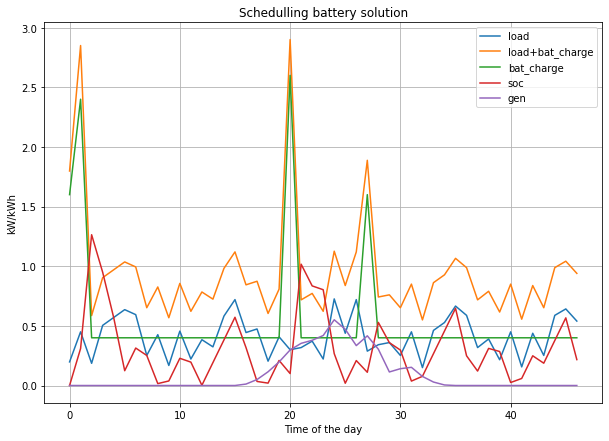

In [41]:
flex.makeplot(48,state_track[:,3],action_track,env.data[:,0],env.data[:,1],env) # O Tempo e o Env não estão a fazer nada
# makeplot(T,soc,sol,gen,load,env): Tempo, SOC, Bat_Charge, Generation, load, env

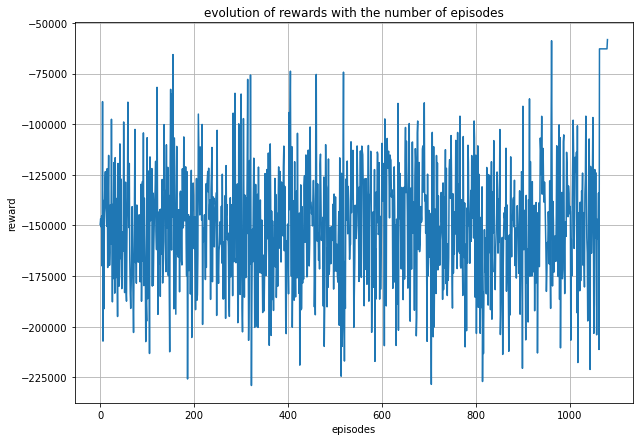

In [42]:
flex.reward_plot(env.R_Total)

In [43]:
evaluate_policy(model,env, n_eval_episodes=10)

/home/acr/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005
-62820.20000000005


(-62820.19885253906, 0.0)

# Studying the battery

In [44]:
SOC = state_track[:,3]
bat_charge = action_track # Bat_charge
gen = env.data[:,0]
load = env.data[:,1]

In [45]:
state_track

array([[ 0.0000000e+00,  0.0000000e+00,  1.9800000e-01,  0.0000000e+00,
         0.0000000e+00,  1.7000000e-01,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 1.0000000e+00,  0.0000000e+00,  4.4999999e-01,  3.1000000e-01,
         0.0000000e+00,  1.7000000e-01, -3.7016001e+03,  0.0000000e+00,
        -3.7016001e+03],
       [ 2.0000000e+00,  0.0000000e+00,  1.8600000e-01,  1.2640001e+00,
         3.1000000e-01,  1.7000000e-01, -7.4040000e+03,  0.0000000e+00,
        -3.7023999e+03],
       [ 3.0000000e+00,  0.0000000e+00,  5.0400001e-01,  9.4999999e-01,
         1.2640001e+00,  1.7000000e-01, -7.1043999e+03,  0.0000000e+00,
         2.9960001e+02],
       [ 4.0000000e+00,  0.0000000e+00,  5.6999999e-01,  5.6999999e-01,
         9.4999999e-01,  1.7000000e-01, -6.8047998e+03,  0.0000000e+00,
         2.9960001e+02],
       [ 5.0000000e+00,  0.0000000e+00,  6.3599998e-01,  1.2400000e-01,
         5.6999999e-01,  1.7000000e-01, -6.5052002e+03,  0.0000000e+00,
         2.

In [46]:
def myplot(x):
    plt.figure(figsize=(10,6))
    plt.plot(x)

In [47]:
env.data

array([[0.0, 0.198],
       [0.0, 0.44999999999999996],
       [0.0, 0.186],
       [0.0, 0.504],
       [0.0, 0.5700000000000001],
       [0.0, 0.636],
       [0.0, 0.5940000000000001],
       [0.0, 0.252],
       [0.0, 0.42599999999999993],
       [0.0, 0.168],
       [0.0, 0.45599999999999996],
       [0.0, 0.22199999999999998],
       [0.0, 0.384],
       [0.0, 0.324],
       [0.0, 0.5820000000000001],
       [0.0, 0.72],
       [0.012, 0.44399999999999995],
       [0.05, 0.474],
       [0.115, 0.20400000000000001],
       [0.1975, 0.40800000000000003],
       [0.298, 0.30000000000000004],
       [0.3535, 0.318],
       [0.379, 0.372],
       [0.419, 0.22199999999999998],
       [0.551, 0.726],
       [0.4715, 0.43799999999999994],
       [0.3345, 0.72],
       [0.4165, 0.28800000000000003],
       [0.3045, 0.342],
       [0.1135, 0.36],
       [0.141, 0.252],
       [0.1525, 0.44999999999999996],
       [0.076, 0.15000000000000002],
       [0.029, 0.46199999999999997],
       [0.0

Text(0, 0.5, 'gen')

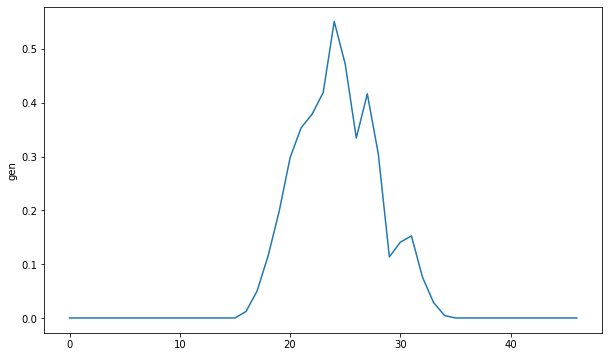

In [48]:
myplot(gen)
plt.ylabel('gen')

In [49]:
gen

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.012, 0.05, 0.115, 0.1975, 0.298, 0.3535, 0.379,
       0.419, 0.551, 0.4715, 0.3345, 0.4165, 0.3045, 0.1135, 0.141,
       0.1525, 0.076, 0.029, 0.0045, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

Text(0, 0.5, 'load')

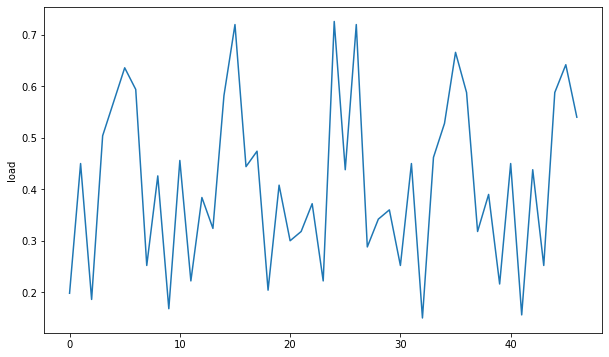

In [50]:
myplot(load)
plt.ylabel('load')

Text(0, 0.5, 'SOC')

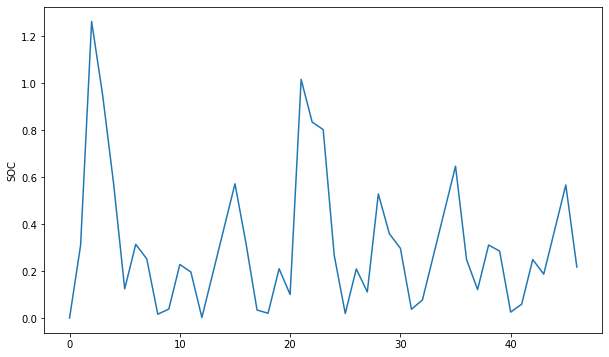

In [51]:
myplot(SOC)
plt.ylabel('SOC')

Text(0, 0.5, 'Battery Charge')

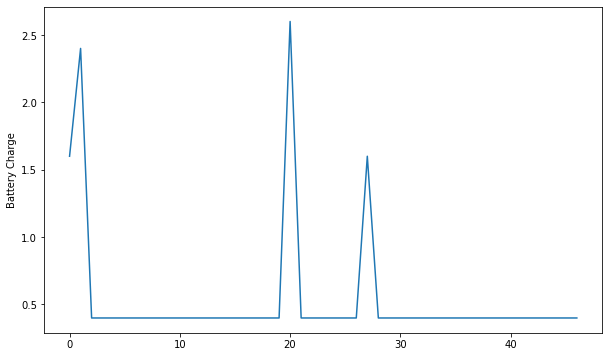

In [52]:
myplot(bat_charge)
plt.ylabel('Battery Charge')

Text(0, 0.5, 'Rewards track')

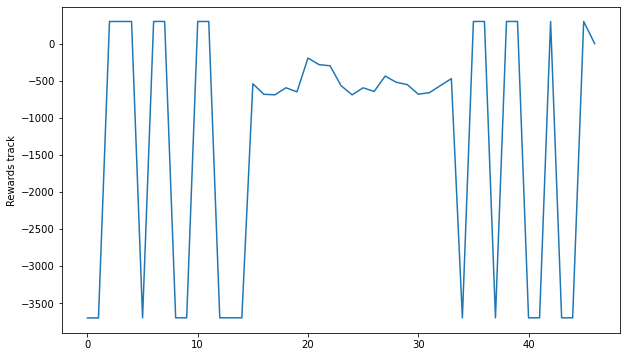

In [53]:
myplot(rewards_track)
plt.ylabel('Rewards track')

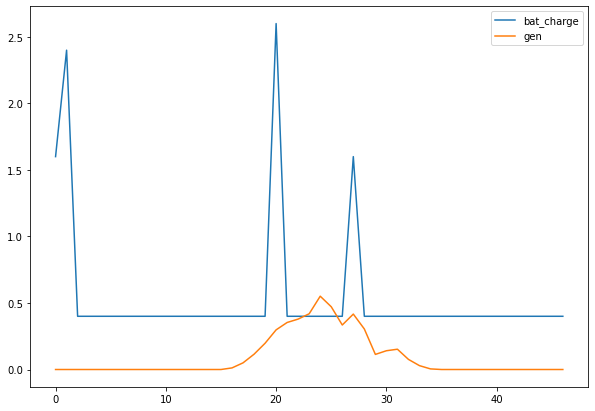

In [54]:
plt.figure(figsize=(10,7))
plt.legend
plt.plot(bat_charge,label='bat_charge')
plt.plot(gen,label='gen')
plt.legend()
plt.show()

In [55]:
eta = 0.95
dh=30*(1/60)

In [56]:
SOC

array([0.   , 0.31 , 1.264, 0.95 , 0.57 , 0.124, 0.314, 0.252, 0.016,
       0.038, 0.228, 0.196, 0.002, 0.192, 0.382, 0.572, 0.318, 0.034,
       0.02 , 0.21 , 0.1  , 1.017, 0.835, 0.803, 0.267, 0.019, 0.209,
       0.111, 0.529, 0.359, 0.297, 0.037, 0.077, 0.267, 0.457, 0.647,
       0.249, 0.121, 0.311, 0.285, 0.025, 0.059, 0.249, 0.187, 0.377,
       0.567, 0.217], dtype=float32)

In [57]:
gen

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.012, 0.05, 0.115, 0.1975, 0.298, 0.3535, 0.379,
       0.419, 0.551, 0.4715, 0.3345, 0.4165, 0.3045, 0.1135, 0.141,
       0.1525, 0.076, 0.029, 0.0045, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [58]:
C=np.array(bat_charge)*eta*dh
Sum=[]
Sumi = 0
for i in range(len(np.array(bat_charge)*eta*dh)):
    Sumi+= C[i]
    Sum.append(Sumi)
Sum

[0.76,
 1.9000000000000001,
 2.0900000000000003,
 2.2800000000000002,
 2.47,
 2.66,
 2.85,
 3.04,
 3.23,
 3.42,
 3.61,
 3.8,
 3.9899999999999998,
 4.18,
 4.37,
 4.5600000000000005,
 4.750000000000001,
 4.940000000000001,
 5.130000000000002,
 5.320000000000002,
 6.5550000000000015,
 6.745000000000002,
 6.935000000000002,
 7.125000000000003,
 7.315000000000003,
 7.5050000000000034,
 7.695000000000004,
 8.455000000000004,
 8.645000000000003,
 8.835000000000003,
 9.025000000000002,
 9.215000000000002,
 9.405000000000001,
 9.595,
 9.785,
 9.975,
 10.165,
 10.354999999999999,
 10.544999999999998,
 10.734999999999998,
 10.924999999999997,
 11.114999999999997,
 11.304999999999996,
 11.494999999999996,
 11.684999999999995,
 11.874999999999995,
 12.064999999999994]

In [59]:
SOC

array([0.   , 0.31 , 1.264, 0.95 , 0.57 , 0.124, 0.314, 0.252, 0.016,
       0.038, 0.228, 0.196, 0.002, 0.192, 0.382, 0.572, 0.318, 0.034,
       0.02 , 0.21 , 0.1  , 1.017, 0.835, 0.803, 0.267, 0.019, 0.209,
       0.111, 0.529, 0.359, 0.297, 0.037, 0.077, 0.267, 0.457, 0.647,
       0.249, 0.121, 0.311, 0.285, 0.025, 0.059, 0.249, 0.187, 0.377,
       0.567, 0.217], dtype=float32)

In [60]:
# bat_charge

In [61]:
# self.charge_lim=3
charge_lim=3

charge_steps=np.linspace(0,charge_lim,int((charge_lim/0.2)+1))
charge_steps

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. ])

In [33]:
import numpy as np

In [34]:
charge_lim =2
minimum_charge_step=0.5

In [35]:
charge_steps=np.linspace(0,charge_lim,int((charge_lim/minimum_charge_step)+1)) #definition of actions
charge_steps

array([0. , 0.5, 1. , 1.5, 2. ])

In [36]:
discharge_steps=np.linspace(-charge_lim,0,int((charge_lim/minimum_charge_step)+1))
discharge_steps

array([-2. , -1.5, -1. , -0.5,  0. ])

In [52]:
action=23

In [53]:
int((action-1)/len(charge_steps))

4

In [54]:
int(action-1-int((action-1)/len(charge_steps))*len(charge_steps))

2